Learning the basics of neural nets by implementing basic algos from scratch. This notebook is used to test and demo backprop.py.
It is is based on Andrej Karpathy's https://github.com/karpathy/micrograd.

First, let's test and look at the autograd layer in backprop.py. The code below creates a graph function to visualize a DAG of Values and uses that to visualize the graph created by performing operations on Value's

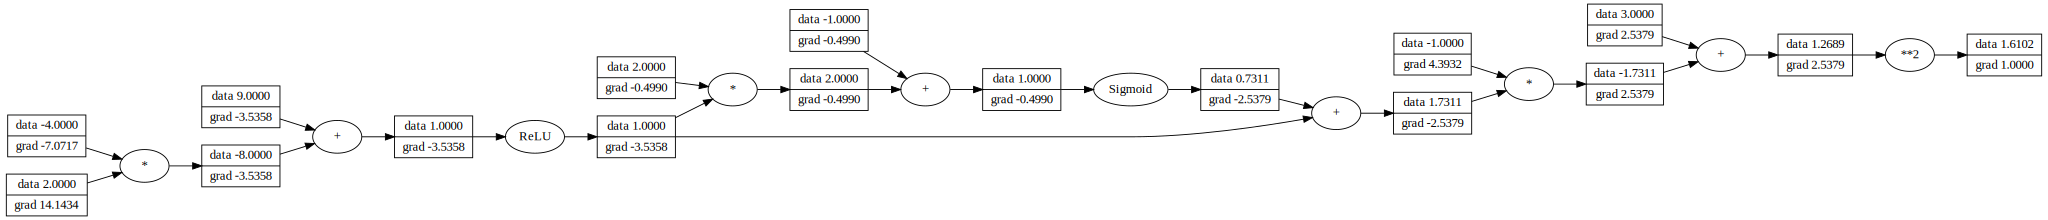

In [1]:
from backprop import *
from graphviz import Digraph
def graph(self):
    def trace(root):
        nodes, edges = set(), set()
        def build(v):
            if v not in nodes:
                nodes.add(v)
                for child in v._prev:
                    edges.add((child, v))
                    build (child)
        build(root)
        return nodes, edges
    
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})
    nodes, edges = trace(self)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label = f"data {n.data:.4f} | grad {n.grad:.4f}", shape="record")
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

x = Value(2.0)
y = Value(3.0)

w1 = Value(-4.0)
b1 = Value(9.0)
y1 = relu(w1 * x + b1)

w2 = Value(2.0)
b2 = Value(-1.0)
yhat = sigmoid(w2 * y1 + b2) + y1

loss = (y - yhat)**2

loss.backward()
graph(loss)


Next, let's look at how Modules (build on top of Values) can be built run

Model: Sequential([Layer(inputs=2, outputs=4), ReLU, Layer(inputs=4, outputs=2)])
Input: [1.0, 2.0], output: [0.4846687936007914, -0.7162607992561989], expected output: [0.0, 1.0], loss: 1.5902


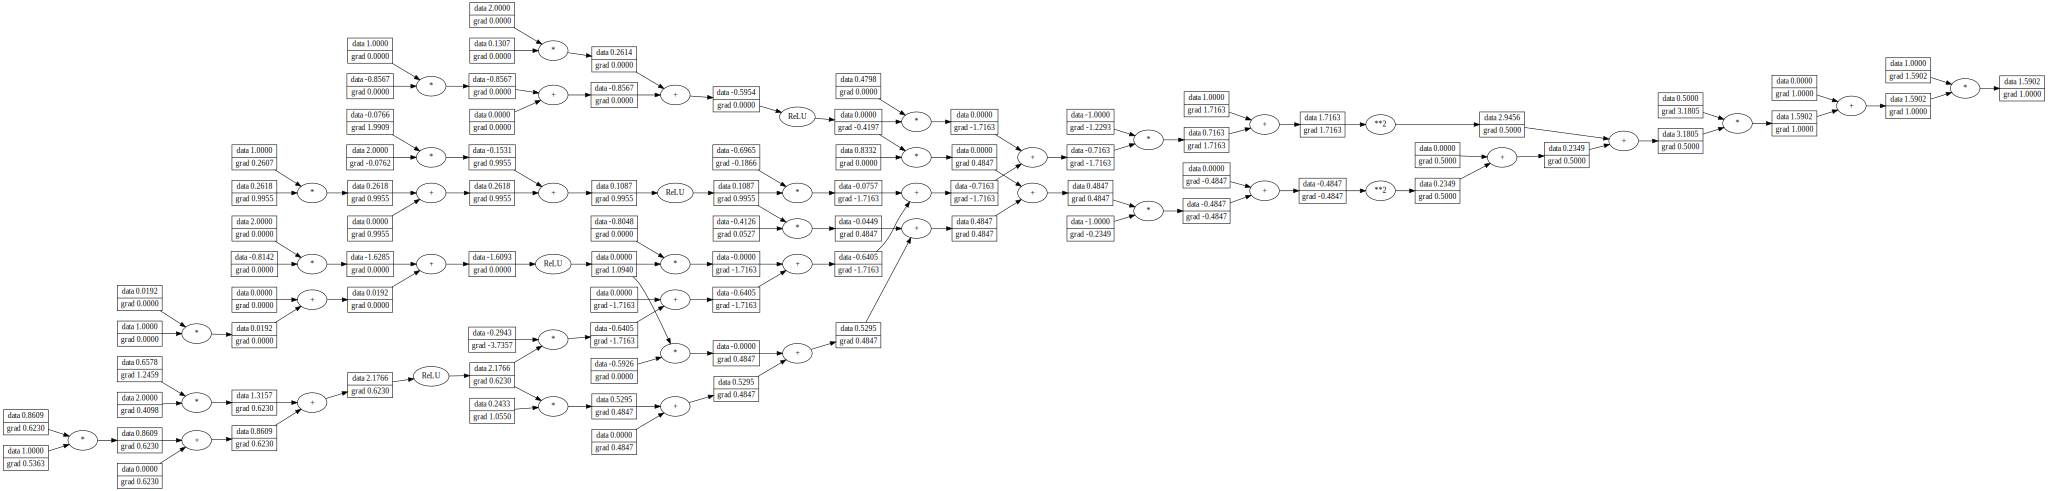

In [2]:
# Simple 3-layer model, internally using Value objects as weights for the linear layers
model = Sequential([Layer(2, 4), ReLU(), Layer(4, 2)])
print (f"Model: {model}")

# Some really simple training data; one example
x = [1.0, 2.0]
y = [0.0, 1.0]

# Run the model, compute the MSE loss, and show the results
y_hat = model(x)
loss = mse_loss([y], [y_hat])
print (f"Input: {x}, output: {[yhi.data for yhi in y_hat]}, expected output: {y}, loss: {loss.data:.4f}")

# Backpropagate the loss, and show the gradient of all the model parameters
loss.backward()
graph(loss)

Simple 1 neuron test on the identity function

In [3]:
from backprop import *

EPOCHS = 20
BATCH_SIZE = 8
LR = .01
random.seed(1337)

test_name = "1 neuron, 1 input identity"
model = Sequential([Layer(1, 1)])
print (model)

# Training the model set: 128 records; each col of x is a random int between -20 and 20, y = x
X = [[random.randint(-20, 20)] for _ in range(128)]
y = X
opt = SGD(model, lr=LR, gradient_cliping=1)
fit (model, X, y, loss_fn=mse_loss, optimizer=opt, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=True)

# Create similar test data
x_test = [[random.randint(-20, 20)] for _ in range(32)]
y_test = x_test
loss = test (model, x_test, y_test, loss_fn=mse_loss)[0].data

if loss < 0.1:
    print (f"{test_name} passed with MSE {loss:.4f}")
else:
    print (f"{test_name} FAILED with MSE {loss:.4f}")
    for x, y in zip(x_test, y_test):
        print (f"\tInput: {x[0]}. Output: {model(x).data:.4f}. Expected: {y[0]})")


Sequential([Layer(inputs=1, outputs=1)])
Epoch 0: loss=72.4930
Epoch 1: loss=43.1228
Epoch 2: loss=20.8286
Epoch 3: loss=6.6708
Epoch 4: loss=0.6494
Epoch 5: loss=0.0118
Epoch 6: loss=0.0071
Epoch 7: loss=0.0067
Epoch 8: loss=0.0044
Epoch 9: loss=0.0044
Epoch 10: loss=0.0034
Epoch 11: loss=0.0032
Epoch 12: loss=0.0040
Epoch 13: loss=0.0036
Epoch 14: loss=0.0029
Epoch 15: loss=0.0040
Epoch 16: loss=0.0036
Epoch 17: loss=0.0037
Epoch 18: loss=0.0030
Epoch 19: loss=0.0024
1 neuron, 1 input identity passed with MSE 0.0027


2 layer, 21 neuron + ReLU test; y = x^2

In [4]:
from backprop import *

EPOCHS = 30
BATCH_SIZE = 16
LR = .5
LR_DECAY = 0.01
random.seed(1337)

test_name = "2 layers + ReLU activation, 1 input x^2"

model = Sequential([Layer(1, 10), ReLU(), Layer(10, 10), ReLU(), Layer(10, 1)])
print (model)
print (f"Total parameters: {len(model.parameters())}")
x_train = [[random.randint(-20, 20)] for _ in range(512)]
y_train = [[x[0]**2] for x in x_train]
opt = SGD(model, lr=LR, gradient_cliping=1, lr_decay=LR_DECAY)
fit (model, x_train, y_train, loss_fn=mse_loss, optimizer=opt, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=True)

x_test = [[random.randint(-20, 20)] for _ in range(32)]
y_test = [[x[0]**2] for x in x_test]
loss = test (model, x_test, y_test, loss_fn=mse_loss)[0].data

if loss < 150:
    print (f"{test_name} passed with MSE {loss:.4f}")
else:
    print (f"{test_name} FAILED with MSE {loss:.4f}")
    for x, y in zip(x_test, y_test):
        print (f"\tInput: {x[0]}. Output: {model(x).data:.4f}. Expected: {y[0]}")


Sequential([Layer(inputs=1, outputs=10), ReLU, Layer(inputs=10, outputs=10), ReLU, Layer(inputs=10, outputs=1)])
Total parameters: 141
Epoch 0: loss=33847.3984
Epoch 1: loss=12729.7103
Epoch 2: loss=8293.8474
Epoch 3: loss=4747.0631
Epoch 4: loss=2696.0152
Epoch 5: loss=1572.1887
Epoch 6: loss=928.1748
Epoch 7: loss=626.7288
Epoch 8: loss=454.0439
Epoch 9: loss=321.4198
Epoch 10: loss=227.1017
Epoch 11: loss=173.0920
Epoch 12: loss=147.2032
Epoch 13: loss=133.7549
Epoch 14: loss=117.8599
Epoch 15: loss=108.5663
Epoch 16: loss=99.9307
Epoch 17: loss=96.1418
Epoch 18: loss=92.2410
Epoch 19: loss=90.2181
Epoch 20: loss=88.4640
Epoch 21: loss=87.5333
Epoch 22: loss=85.9837
Epoch 23: loss=85.4550
Epoch 24: loss=85.8219
Epoch 25: loss=84.8013
Epoch 26: loss=84.2848
Epoch 27: loss=84.5235
Epoch 28: loss=84.2027
Epoch 29: loss=83.9943
2 layers + ReLU activation, 1 input x^2 passed with MSE 101.8438


Now let's try a classification problem from Andrey's notebook

Sequential([Layer(inputs=2, outputs=16), ReLU, Layer(inputs=16, outputs=16), ReLU, Layer(inputs=16, outputs=1)])
Epoch 0: loss=0.8958, accuracy=50.0
Epoch 1: loss=1.6894, accuracy=81.0
Epoch 2: loss=0.6733, accuracy=77.0
Epoch 3: loss=0.7966, accuracy=82.0
Epoch 4: loss=0.3782, accuracy=84.0
Epoch 5: loss=0.3162, accuracy=88.0
Epoch 6: loss=0.2797, accuracy=88.0
Epoch 7: loss=0.2605, accuracy=91.0
Epoch 8: loss=0.2435, accuracy=92.0
Epoch 9: loss=0.2275, accuracy=91.0
Epoch 10: loss=0.2098, accuracy=92.0
Epoch 11: loss=0.2030, accuracy=92.0
Epoch 12: loss=0.2145, accuracy=94.0
Epoch 13: loss=0.2469, accuracy=90.0
Epoch 14: loss=0.2515, accuracy=92.0
Epoch 15: loss=0.2151, accuracy=91.0
Epoch 16: loss=0.2121, accuracy=93.0
Epoch 17: loss=0.1571, accuracy=95.0
Epoch 18: loss=0.1439, accuracy=95.0
Epoch 19: loss=0.1597, accuracy=94.0
Epoch 20: loss=0.2020, accuracy=94.0
Epoch 21: loss=0.1842, accuracy=91.0
Epoch 22: loss=0.1590, accuracy=95.0
Epoch 23: loss=0.1255, accuracy=95.0
Epoch 24:

(-1.548639298268643, 1.951360701731357)

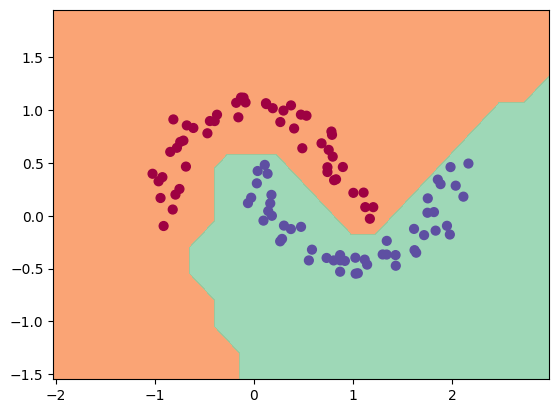

In [5]:
from backprop import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs

EPOCHS = 100

np.random.seed(1337)
random.seed(1337)

X, y = make_moons(n_samples=100, noise=0.1)
y = list([yi*2 - 1] for yi in y) # make y be a list of lists, each -1 or 1

# visualize in 2D
#plt.figure(figsize=(5,5))
#plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

model = Sequential([Layer(2, 16), ReLU(), Layer(16, 16), ReLU(), Layer(16, 1)])
print (model)

# train the model using SGD
opt = SGD(model, lr=1, lr_decay=.02)
fit (model, X, y, loss_fn=svm_max_margin_loss, optimizer=opt, epochs=EPOCHS, regularization_alpha=1e-4, batch_size=None, metrics=(accuracy,), verbose=True)

# visualize decision boundary
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())